In [1]:
# ==============================================
# End-to-end (4 subgroup models: Gender × AgeBin) + BMI feature:
# Load → Detect ID/Target/Gender → Drop MTRANS/SMOKE → +BMI →
# Round Age → AgeBin (0:<24, 1:>=24) →
# Split to 4 groups → Per-group 5-Fold XGB (ES) → Predict → submission.csv
# ==============================================

# -------- Imports --------
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.base import clone

import xgboost as xgb

# -------- Paths --------
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SAMPLE_SUB_PATH = "sample_submission.csv"

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
NUM_CLASSES_EXPECTED = 7   # used only for a sanity warning

# -------- Helpers --------
def norm_col(s: str) -> str:
    if s is None: return s
    return str(s).replace("\ufeff", "").strip().lower()

def build_norm_map(cols):
    fwd = {c: norm_col(c) for c in cols}
    rev = {}
    for orig, n in fwd.items():
        if n not in rev:
            rev[n] = orig
    return fwd, rev

def find_id_and_label(sample_sub, train, test):
    ss_fwd, _ = build_norm_map(sample_sub.columns)
    tr_fwd, _ = build_norm_map(train.columns)
    te_fwd, _ = build_norm_map(test.columns)

    ss_norm_cols = [ss_fwd[c] for c in sample_sub.columns]
    tr_norm_cols = [tr_fwd[c] for c in train.columns]
    te_norm_cols = [te_fwd[c] for c in test.columns]

    id_norm, label_norm = None, None
    if len(ss_norm_cols) == 2:
        c1, c2 = ss_norm_cols
        if c1 in te_norm_cols and c2 not in te_norm_cols:
            id_norm, label_norm = c1, c2
        elif c2 in te_norm_cols and c1 not in te_norm_cols:
            id_norm, label_norm = c2, c1
        else:
            if c1 in te_norm_cols and c1 in tr_norm_cols:
                id_norm, label_norm = c1, c2
            elif c2 in te_norm_cols and c2 in tr_norm_cols:
                id_norm, label_norm = c2, c1

    if id_norm is None:
        for cand in ["id", "row_id", "index", "sample_id"]:
            if cand in te_norm_cols and cand in tr_norm_cols:
                id_norm = cand
                break

    if label_norm is None:
        candidates = [c for c in ss_norm_cols if c != id_norm]
        if len(candidates) == 1:
            label_norm = candidates[0]

    if label_norm is None:
        for cand in ["label", "target", "class", "y", "weightcategory", "nobeyesdad"]:
            if cand in tr_norm_cols and cand != id_norm:
                label_norm = cand
                break

    if label_norm is None:
        for c in reversed(tr_norm_cols):
            if c != id_norm:
                label_norm = c
                break

    return {
        "id_norm": id_norm,
        "label_norm": label_norm,
        "id_in_train": build_norm_map(train.columns)[1].get(id_norm, None),
        "id_in_test": build_norm_map(test.columns)[1].get(id_norm, None),
        "id_in_sample": build_norm_map(sample_sub.columns)[1].get(id_norm, None),
        "label_in_train": build_norm_map(train.columns)[1].get(label_norm, None),
        "label_in_sample": build_norm_map(sample_sub.columns)[1].get(label_norm, None),
    }

def infer_feature_types(df):
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return num_cols, cat_cols

def detect_gender_column(df):
    candidates = [c for c in df.columns if norm_col(c) in {"gender","sex"}]
    if candidates:
        return candidates[0]
    for c in df.columns:
        vals = pd.Series(df[c].dropna().astype(str).str.lower().str.strip()).unique()
        if len(vals) in (2, 3):
            if any(v.startswith("m") for v in vals) and any(v.startswith("f") for v in vals):
                return c
    return None

def split_by_gender(series):
    s = series.astype(str).str.lower().str.strip()
    male_mask = s.str.startswith(("m","1","true"))
    female_mask = s.str.startswith(("f","0","false"))
    if male_mask.sum()==0 and female_mask.sum()==0:
        top = s.value_counts().index.tolist()
        if len(top)>=2:
            male_mask = s==top[0]
            female_mask = s==top[1]
    return male_mask, female_mask

def add_bmi(df):
    """Compute BMI exactly as Weight / (Height ** 2)."""
    if ("Weight" in df.columns) and ("Height" in df.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            df["BMI"] = df["Weight"].astype(float) / (df["Height"].astype(float) ** 2)
        df["BMI"] = df["BMI"].replace([np.inf, -np.inf], np.nan)
    return df


def round_and_bin_age(df):
    """Round Age, then make AgeBin = 0 if <24, 1 if >=24."""
    if "Age" in df.columns:
        age_num = pd.to_numeric(df["Age"], errors="coerce").round()
        df["Age"] = age_num
        df["AgeBin"] = (age_num >= 24).astype("Int8")
    return df

# -------- Load data --------
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

# Drop not-used columns
for c in ["MTRANS","SMOKE"]:
    if c in train.columns: train.drop(columns=[c], inplace=True)
    if c in test.columns:  test.drop(columns=[c], inplace=True)

# >>> Add BMI + Round Age + AgeBin (train & test) <<<
train = add_bmi(train)
test  = add_bmi(test)
train = round_and_bin_age(train)
test  = round_and_bin_age(test)

info = find_id_and_label(sample_sub, train, test)

ID_COL_TRAIN   = info["id_in_train"]
ID_COL_TEST    = info["id_in_test"]
ID_COL_SAMPLE  = info["id_in_sample"]
TARGET_COL     = info["label_in_train"]
LABEL_COL_SAMP = info["label_in_sample"]

if TARGET_COL is None:
    raise ValueError("Could not detect the target column. Please ensure sample_submission and train headers align.")
if LABEL_COL_SAMP is None:
    ss_cols = list(sample_sub.columns)
    others = [c for c in ss_cols if c != ID_COL_SAMPLE]
    if len(others)==1:
        LABEL_COL_SAMP = others[0]
    else:
        raise ValueError("Could not detect label header in sample_submission.csv")

print(f"[Detected] Target in train: '{TARGET_COL}', Label in sample_sub: '{LABEL_COL_SAMP}'")
if ID_COL_TRAIN and ID_COL_TEST:
    print(f"[Detected] ID in train: '{ID_COL_TRAIN}', ID in test: '{ID_COL_TEST}'")

# -------- Target / Features --------
y = train[TARGET_COL].copy()
X = train.drop(columns=[TARGET_COL]).copy()
if ID_COL_TRAIN in X.columns:
    X.drop(columns=[ID_COL_TRAIN], inplace=True)

test_features = test.copy()
if ID_COL_TEST in test_features.columns:
    test_ids = test_features[ID_COL_TEST].copy()
    test_features.drop(columns=[ID_COL_TEST], inplace=True)
else:
    test_ids = pd.Series(np.arange(len(test_features)), name="id")

# -------- Label encode target --------
le = LabelEncoder()
y_enc = le.fit_transform(y)
classes = list(le.classes_)
if len(classes) != NUM_CLASSES_EXPECTED:
    print(f"[Warn] Expected {NUM_CLASSES_EXPECTED} classes but found {len(classes)}. Proceeding.")

# -------- Detect gender column and split (then 4-way split with AgeBin) --------
gender_col = detect_gender_column(pd.concat([X, test_features], axis=0))
if gender_col is None:
    raise ValueError("Could not detect a gender column (e.g., 'Gender' or 'SEX'). Please confirm the column name.")
if "AgeBin" not in X.columns:
    raise ValueError("AgeBin not found. Check round_and_bin_age step.")

male_mask, female_mask = split_by_gender(train[gender_col])
test_male_mask, test_female_mask = split_by_gender(test_features[gender_col])

young_mask = (train["AgeBin"] == 0)
old_mask   = (train["AgeBin"] == 1)
test_young_mask = (test_features["AgeBin"] == 0)
test_old_mask   = (test_features["AgeBin"] == 1)

print(f"[Info] Train counts - M<24:{int((male_mask & young_mask).sum())}  M>=24:{int((male_mask & old_mask).sum())}  F<24:{int((female_mask & young_mask).sum())}  F>=24:{int((female_mask & old_mask).sum())}")
print(f"[Info] Test  counts - M<24:{int((test_male_mask & test_young_mask).sum())}  M>=24:{int((test_male_mask & test_old_mask).sum())}  F<24:{int((test_female_mask & test_young_mask).sum())}  F>=24:{int((test_female_mask & test_old_mask).sum())}")

# We drop split columns (gender, Age, AgeBin) inside each subgroup (constants after split)
DROP_IN_GROUP = set([gender_col, "Age", "AgeBin"])

def train_group_and_predict(X_grp, y_enc_grp, test_grp, group_name):
    # remove split columns from features if present
    cols_to_use = [c for c in X_grp.columns if c not in DROP_IN_GROUP]
    Xg = X_grp[cols_to_use].copy()
    Xtestg = test_grp[cols_to_use].copy()

    # feature types
    num_cols, cat_cols = infer_feature_types(Xg)

    # Preprocessor: sparse OHE (works with xgb DMatrix)
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ])
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=1.0
    )

    # XGBoost params
    xgb_params = {
        "objective": "multi:softprob",
        "num_class": len(classes),
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "max_depth": 6,
        "min_child_weight": 2,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "lambda": 1.0,
        "alpha": 0.0,
        "eta": 0.03,
        "nthread": N_JOBS,
        "seed": RANDOM_STATE,
    }
    NUM_BOOST_ROUND = 20000
    EARLY_STOP = 200

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    oof_group = np.zeros((len(Xg), len(classes)), dtype=np.float32)
    test_group_pred = np.zeros((len(Xtestg), len(classes)), dtype=np.float32)
    fold_best = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(Xg, y_enc_grp), start=1):
        print(f"\n[{group_name}] Fold {fold}/{N_FOLDS}")
        X_tr, X_va = Xg.iloc[tr_idx], Xg.iloc[va_idx]
        y_tr, y_va = y_enc_grp[tr_idx], y_enc_grp[va_idx]

        prep = clone(preprocessor)
        Xtr = prep.fit_transform(X_tr)
        Xva = prep.transform(X_va)

        dtrain = xgb.DMatrix(Xtr, label=y_tr)
        dval   = xgb.DMatrix(Xva, label=y_va)

        bst = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds=EARLY_STOP,
            verbose_eval=False
        )
        best_round = int(bst.best_iteration + 1)
        fold_best.append(best_round)
        print(f"[{group_name}] Best iteration: {best_round}")

        oof_proba = bst.predict(dval, iteration_range=(0, best_round))
        oof_group[va_idx] = oof_proba

        # test preds for this fold
        Xtest_tf = prep.transform(Xtestg)
        dtest = xgb.DMatrix(Xtest_tf)
        test_group_pred += bst.predict(dtest, iteration_range=(0, best_round)) / N_FOLDS

    # OOF summary for the group
    oof_argmax = np.argmax(oof_group, axis=1)
    acc_g = accuracy_score(y_enc_grp, oof_argmax)
    f1_g = f1_score(y_enc_grp, oof_argmax, average="macro")
    print(f"\n[{group_name}] OOF Accuracy: {acc_g:.4f} | Macro F1: {f1_g:.4f}")
    print(f"[{group_name}] Best iterations: {fold_best} | Median: {int(np.median(fold_best))}")

    return oof_group, test_group_pred

# -------- Build 4 groups and train --------
groups = [
    ("MALE_<24",   (male_mask & young_mask),   (test_male_mask & test_young_mask)),
    ("MALE_>=24",  (male_mask & old_mask),     (test_male_mask & test_old_mask)),
    ("FEMALE_<24", (female_mask & young_mask), (test_female_mask & test_young_mask)),
    ("FEMALE_>=24",(female_mask & old_mask),   (test_female_mask & test_old_mask)),
]

oof_full = np.zeros((len(X), len(classes)), dtype=np.float32)
test_pred_proba = np.zeros((len(test_features), len(classes)), dtype=np.float32)

for grp_name, tr_mask, te_mask in groups:
    if tr_mask.sum() == 0:
        print(f"[Warn] No training rows for group {grp_name}; skipping.")
        continue

    X_grp = X[tr_mask].reset_index(drop=True)
    y_grp = y_enc[tr_mask.values]
    test_grp = test_features[te_mask].reset_index(drop=True)

    grp_oof, grp_test_pred = train_group_and_predict(X_grp, y_grp, test_grp, grp_name)

    # place OOF back
    oof_full[tr_mask.values] = grp_oof
    # place test predictions back
    test_pred_proba[te_mask.values] = grp_test_pred

# -------- Overall OOF report --------
oof_labels = np.argmax(oof_full, axis=1)
oof_acc = accuracy_score(y_enc, oof_labels)
oof_f1 = f1_score(y_enc, oof_labels, average="macro")
print("\n========== OVERALL OOF ==========")
print(f"OOF Accuracy: {oof_acc:.4f} | OOF Macro F1: {oof_f1:.4f}")
try:
    print("\nOOF Classification Report:\n",
          classification_report(y_enc, oof_labels, target_names=classes))
except Exception as e:
    print(f"[Info] Could not print classification report: {e}")

# -------- Build submission --------
test_pred_int = np.argmax(test_pred_proba, axis=1)
test_pred_labels = le.inverse_transform(test_pred_int)

ss_cols = list(sample_sub.columns)
ID_HEADER = ID_COL_SAMPLE if ID_COL_SAMPLE in sample_sub.columns else None
LABEL_HEADER = LABEL_COL_SAMP

sub = pd.DataFrame()
if ID_HEADER is not None and ID_COL_TEST in test.columns:
    sub[ID_HEADER] = test[ID_COL_TEST].values
elif ID_HEADER is not None:
    sub[ID_HEADER] = np.arange(len(test_features))
sub[LABEL_HEADER] = test_pred_labels

# Reorder/complete to match sample_sub exactly
for c in ss_cols:
    if c not in sub.columns:
        sub[c] = sample_sub[c].iloc[0] if len(sample_sub[c]) else None
sub = sub[ss_cols]

sub.to_csv("submission.csv", index=False)
print("\nSaved submission.csv")
print(sub.head(10))


[Detected] Target in train: 'WeightCategory', Label in sample_sub: 'WeightCategory'
[Detected] ID in train: 'id', ID in test: 'id'
[Info] Train counts - M<24:4551  M>=24:3232  F<24:4755  F>=24:2995
[Info] Test  counts - M<24:1442  M>=24:1111  F<24:1623  F>=24:1049

[MALE_<24] Fold 1/5


C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[MALE_<24] Best iteration: 243

[MALE_<24] Fold 2/5
[MALE_<24] Best iteration: 329

[MALE_<24] Fold 3/5
[MALE_<24] Best iteration: 253

[MALE_<24] Fold 4/5
[MALE_<24] Best iteration: 322

[MALE_<24] Fold 5/5
[MALE_<24] Best iteration: 292

[MALE_<24] OOF Accuracy: 0.8684 | Macro F1: 0.7494
[MALE_<24] Best iterations: [243, 329, 253, 322, 292] | Median: 292

[MALE_>=24] Fold 1/5


C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[MALE_>=24] Best iteration: 181

[MALE_>=24] Fold 2/5
[MALE_>=24] Best iteration: 197

[MALE_>=24] Fold 3/5
[MALE_>=24] Best iteration: 260

[MALE_>=24] Fold 4/5
[MALE_>=24] Best iteration: 274

[MALE_>=24] Fold 5/5
[MALE_>=24] Best iteration: 230

[MALE_>=24] OOF Accuracy: 0.9032 | Macro F1: 0.5959
[MALE_>=24] Best iterations: [181, 197, 260, 274, 230] | Median: 230

[FEMALE_<24] Fold 1/5


C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[FEMALE_<24] Best iteration: 269

[FEMALE_<24] Fold 2/5
[FEMALE_<24] Best iteration: 291

[FEMALE_<24] Fold 3/5
[FEMALE_<24] Best iteration: 323

[FEMALE_<24] Fold 4/5
[FEMALE_<24] Best iteration: 286

[FEMALE_<24] Fold 5/5
[FEMALE_<24] Best iteration: 255

[FEMALE_<24] OOF Accuracy: 0.9028 | Macro F1: 0.7517
[FEMALE_<24] Best iterations: [269, 291, 323, 286, 255] | Median: 286

[FEMALE_>=24] Fold 1/5
[FEMALE_>=24] Best iteration: 229

[FEMALE_>=24] Fold 2/5
[FEMALE_>=24] Best iteration: 211

[FEMALE_>=24] Fold 3/5
[FEMALE_>=24] Best iteration: 232

[FEMALE_>=24] Fold 4/5
[FEMALE_>=24] Best iteration: 205

[FEMALE_>=24] Fold 5/5
[FEMALE_>=24] Best iteration: 229

[FEMALE_>=24] OOF Accuracy: 0.9219 | Macro F1: 0.6839
[FEMALE_>=24] Best iterations: [229, 211, 232, 205, 229] | Median: 229

========== OVERALL OOF ==========
OOF Accuracy: 0.8965 | OOF Macro F1: 0.8861

OOF Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.92   

In [4]:
# ==============================================
# Evaluate on Kaggle_test.csv (4-group logic)
# Run this AFTER your training code (so that
# X, y_enc, classes, le, groups, and
# train_group_and_predict() are available)
# ==============================================
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -- Load Kaggle test with labels --
kdf = pd.read_csv("Kaggle_test.csv")

# Keep y_true and strip id from features
if "WeightCategory" not in kdf.columns:
    raise KeyError("Expected 'WeightCategory' in Kaggle_test.csv")

y_true = kdf["WeightCategory"].copy()
X_k = kdf.drop(columns=["WeightCategory"], errors="ignore").copy()
if "id" in X_k.columns:
    X_k.drop(columns=["id"], inplace=True)

# Same preprocessing as training
for c in ["MTRANS", "SMOKE"]:
    if c in X_k.columns:
        X_k.drop(columns=[c], inplace=True)

if ("Weight" in X_k.columns) and ("Height" in X_k.columns):
    with np.errstate(divide="ignore", invalid="ignore"):
        X_k["BMI"] = X_k["Weight"].astype(float) / (X_k["Height"].astype(float) ** 2)
    X_k["BMI"] = X_k["BMI"].replace([np.inf, -np.inf], np.nan)

if "Age" in X_k.columns:
    age_num = pd.to_numeric(X_k["Age"], errors="coerce").round()
    X_k["Age"] = age_num
    X_k["AgeBin"] = (age_num >= 24).astype("Int8")

# Detect gender and create 4 subgroup masks on Kaggle set
gender_col_k = detect_gender_column(X_k)
if gender_col_k is None:
    raise ValueError("Could not detect a gender column in Kaggle_test.csv")

km, kf = split_by_gender(X_k[gender_col_k])
ky = (X_k["AgeBin"] == 0)
ko = (X_k["AgeBin"] == 1)

# Prepare prediction container
kaggle_pred_proba = np.zeros((len(X_k), len(classes)), dtype=np.float32)

# Reuse your 'groups' from training:
# groups = [
#   ("MALE_<24",   (male_mask & young_mask),   (test_male_mask & test_young_mask)),
#   ("MALE_>=24",  (male_mask & old_mask),     (test_male_mask & test_old_mask)),
#   ("FEMALE_<24", (female_mask & young_mask), (test_female_mask & test_young_mask)),
#   ("FEMALE_>=24",(female_mask & old_mask),   (test_female_mask & test_old_mask)),
# ]

for grp_name, tr_mask, _ in groups:
    # Map group name to Kaggle mask
    if   grp_name == "MALE_<24":   k_mask = (km & ky)
    elif grp_name == "MALE_>=24":  k_mask = (km & ko)
    elif grp_name == "FEMALE_<24": k_mask = (kf & ky)
    elif grp_name == "FEMALE_>=24":k_mask = (kf & ko)
    else:
        continue

    if tr_mask.sum() == 0 or k_mask.sum() == 0:
        print(f"[Info] Skipping {grp_name}: train rows={int(tr_mask.sum())}, kaggle rows={int(k_mask.sum())}")
        continue

    # Train on this group's train subset; predict on this group's Kaggle rows
    X_grp   = X[tr_mask].reset_index(drop=True)
    y_grp   = y_enc[tr_mask.values]
    Xk_grp  = X_k[k_mask].reset_index(drop=True)

    _, grp_k_pred = train_group_and_predict(X_grp, y_grp, Xk_grp, group_name=f"{grp_name} (Kaggle)")
    kaggle_pred_proba[k_mask.values] = grp_k_pred

# Turn probabilities into labels using same LabelEncoder from training
kaggle_pred_idx = np.argmax(kaggle_pred_proba, axis=1)
y_pred = le.inverse_transform(kaggle_pred_idx)

# Metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")

print("\n============== Kaggle_test Evaluation ==============")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1:.4f}")
try:
    print("\nClassification Report (aligned to train classes):")
    print(classification_report(y_true, y_pred, labels=classes, target_names=classes))
except Exception as e:
    print(f"[Info] classification_report with fixed classes failed: {e}")
    print(classification_report(y_true, y_pred))


C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



[MALE_<24 (Kaggle)] Fold 1/5
[MALE_<24 (Kaggle)] Best iteration: 243

[MALE_<24 (Kaggle)] Fold 2/5
[MALE_<24 (Kaggle)] Best iteration: 329

[MALE_<24 (Kaggle)] Fold 3/5
[MALE_<24 (Kaggle)] Best iteration: 253

[MALE_<24 (Kaggle)] Fold 4/5
[MALE_<24 (Kaggle)] Best iteration: 322

[MALE_<24 (Kaggle)] Fold 5/5
[MALE_<24 (Kaggle)] Best iteration: 292

[MALE_<24 (Kaggle)] OOF Accuracy: 0.8684 | Macro F1: 0.7494
[MALE_<24 (Kaggle)] Best iterations: [243, 329, 253, 322, 292] | Median: 292

[MALE_>=24 (Kaggle)] Fold 1/5


C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[MALE_>=24 (Kaggle)] Best iteration: 181

[MALE_>=24 (Kaggle)] Fold 2/5
[MALE_>=24 (Kaggle)] Best iteration: 197

[MALE_>=24 (Kaggle)] Fold 3/5
[MALE_>=24 (Kaggle)] Best iteration: 260

[MALE_>=24 (Kaggle)] Fold 4/5
[MALE_>=24 (Kaggle)] Best iteration: 274

[MALE_>=24 (Kaggle)] Fold 5/5
[MALE_>=24 (Kaggle)] Best iteration: 230

[MALE_>=24 (Kaggle)] OOF Accuracy: 0.9032 | Macro F1: 0.5959
[MALE_>=24 (Kaggle)] Best iterations: [181, 197, 260, 274, 230] | Median: 230

[FEMALE_<24 (Kaggle)] Fold 1/5


C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[FEMALE_<24 (Kaggle)] Best iteration: 269

[FEMALE_<24 (Kaggle)] Fold 2/5
[FEMALE_<24 (Kaggle)] Best iteration: 291

[FEMALE_<24 (Kaggle)] Fold 3/5
[FEMALE_<24 (Kaggle)] Best iteration: 323

[FEMALE_<24 (Kaggle)] Fold 4/5
[FEMALE_<24 (Kaggle)] Best iteration: 286

[FEMALE_<24 (Kaggle)] Fold 5/5
[FEMALE_<24 (Kaggle)] Best iteration: 255

[FEMALE_<24 (Kaggle)] OOF Accuracy: 0.9028 | Macro F1: 0.7517
[FEMALE_<24 (Kaggle)] Best iterations: [269, 291, 323, 286, 255] | Median: 286

[FEMALE_>=24 (Kaggle)] Fold 1/5
[FEMALE_>=24 (Kaggle)] Best iteration: 229

[FEMALE_>=24 (Kaggle)] Fold 2/5
[FEMALE_>=24 (Kaggle)] Best iteration: 211

[FEMALE_>=24 (Kaggle)] Fold 3/5
[FEMALE_>=24 (Kaggle)] Best iteration: 232

[FEMALE_>=24 (Kaggle)] Fold 4/5
[FEMALE_>=24 (Kaggle)] Best iteration: 205

[FEMALE_>=24 (Kaggle)] Fold 5/5
[FEMALE_>=24 (Kaggle)] Best iteration: 229

[FEMALE_>=24 (Kaggle)] OOF Accuracy: 0.9219 | Macro F1: 0.6839
[FEMALE_>=24 (Kaggle)] Best iterations: [229, 211, 232, 205, 229] | Median: 


=== Confusion Matrix (counts) ===
                          pred:Insufficient_Weight  pred:Normal_Weight  \
true:Insufficient_Weight                       622                  28   
true:Normal_Weight                              42                 663   
true:Obesity_Type_I                              1                   1   
true:Obesity_Type_II                             0                   0   
true:Obesity_Type_III                            0                   0   
true:Overweight_Level_I                          4                  59   
true:Overweight_Level_II                         0                  17   

                          pred:Obesity_Type_I  pred:Obesity_Type_II  \
true:Insufficient_Weight                    0                     0   
true:Normal_Weight                          2                     0   
true:Obesity_Type_I                       630                    17   
true:Obesity_Type_II                       23                   818   
true:Obesity_Type

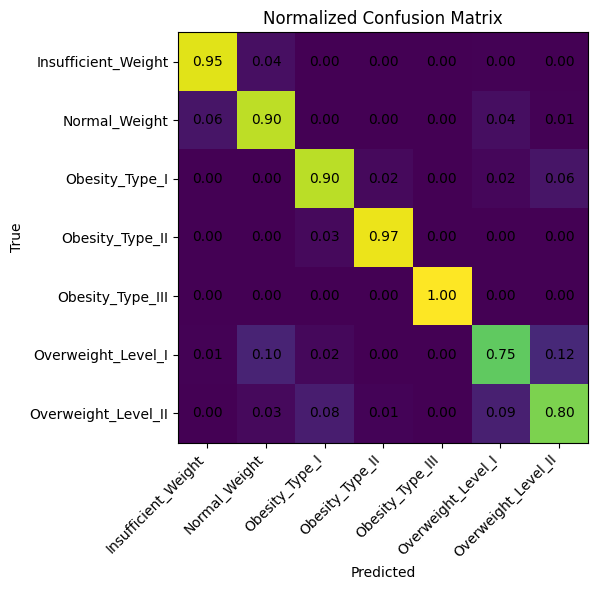

In [5]:
# ==============================================
# Error analysis: what classes are wrong?
# ==============================================
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Order labels to match your training LabelEncoder classes
labels_order = list(classes)  # classes came from: classes = list(le.classes_)

# 1) Confusion matrix (counts) + normalized by true class
cm = confusion_matrix(y_true, y_pred, labels=labels_order)
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

cm_df = pd.DataFrame(cm, index=[f"true:{c}" for c in labels_order],
                        columns=[f"pred:{c}" for c in labels_order])
cmn_df = pd.DataFrame(np.round(cm_norm, 3), index=[f"true:{c}" for c in labels_order],
                                         columns=[f"pred:{c}" for c in labels_order])

print("\n=== Confusion Matrix (counts) ===")
print(cm_df)
print("\n=== Confusion Matrix (row-normalized) ===")
print(cmn_df)

# 2) Per-class precision/recall/F1
print("\n=== Per-class metrics ===")
print(classification_report(y_true, y_pred, labels=labels_order, target_names=labels_order, digits=4))

# 3) Per-class accuracy (diagonal / row total)
per_class_acc = (cm.diagonal() / (cm.sum(axis=1) + 1e-12))
per_class_acc_df = pd.DataFrame({
    "class": labels_order,
    "support": cm.sum(axis=1),
    "accuracy_within_class": np.round(per_class_acc, 4)
}).sort_values("accuracy_within_class")
print("\n=== Per-class accuracy (lowest first) ===")
print(per_class_acc_df)

# 4) Top confusions (off-diagonal pairs)
conf_pairs = []
for i, t in enumerate(labels_order):
    for j, p in enumerate(labels_order):
        if i == j: 
            continue
        cnt = cm[i, j]
        if cnt > 0:
            conf_pairs.append((cnt, t, p, cm_norm[i, j]))
conf_df = pd.DataFrame(conf_pairs, columns=["count", "true", "pred", "row_norm"])
conf_df = conf_df.sort_values(["count", "row_norm"], ascending=[False, False])
print("\n=== Most common confusions (true → pred) ===")
print(conf_df.head(10))

# 5) List misclassified rows (with confidence)
#    - predicted probability and (optionally) 2nd-best class for insight
mis_idx = np.where(y_true.values != y_pred)[0]
if len(mis_idx) == 0:
    print("\n🎉 No misclassifications in Kaggle_test.csv!")
else:
    # predicted idx and confidences
    pred_idx = np.argmax(kaggle_pred_proba, axis=1)
    pred_conf = kaggle_pred_proba[np.arange(len(kaggle_pred_proba)), pred_idx]

    # second-best
    sorted_idx = np.argsort(-kaggle_pred_proba, axis=1)
    second_idx = sorted_idx[:, 1]
    second_label = le.inverse_transform(second_idx)
    second_conf = kaggle_pred_proba[np.arange(len(kaggle_pred_proba)), second_idx]

    mis_df = kdf.iloc[mis_idx].copy()
    mis_df["true_label"] = y_true.iloc[mis_idx].values
    mis_df["pred_label"] = y_pred[mis_idx]
    mis_df["pred_conf"] = np.round(pred_conf[mis_idx], 4)
    mis_df["second_best"] = second_label[mis_idx]
    mis_df["second_conf"] = np.round(second_conf[mis_idx], 4)

    # helpful to see age/gender if available
    if "Age" in mis_df.columns and "AgeBin" in kdf.columns:
        mis_df["AgeBin"] = kdf["AgeBin"].iloc[mis_idx].values
    try:
        if 'gender_col_k' in globals() and gender_col_k in mis_df.columns:
            pass  # already there
    except:
        pass  # ignore if not set

    # Show a compact view
    keep_cols = [c for c in ["id", "Gender", "Age", "AgeBin", "BMI",
                             "true_label", "pred_label", "pred_conf", "second_best", "second_conf"]
                 if c in mis_df.columns]
    print("\n=== Sample of misclassifications (first 20) ===")
    print(mis_df[keep_cols].head(20))

    # Also show counts of mistakes per true class
    mis_counts = mis_df.groupby(["true_label", "pred_label"]).size().reset_index(name="count") \
                       .sort_values("count", ascending=False)
    print("\n=== Misclassification breakdown (true → pred) ===")
    print(mis_counts.head(20))

# 6) Optional: Matplotlib confusion matrix plot (simple)
# (Run only if you want a quick visual; comment out if not needed)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_norm, interpolation='nearest')
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(labels_order)), labels_order, rotation=45, ha='right')
    plt.yticks(range(len(labels_order)), labels_order)
    for i in range(len(labels_order)):
        for j in range(len(labels_order)):
            plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Info] Skipped plot: {e}")


In [7]:
# ==============================================
# Error analysis (text output, custom order)
# ==============================================
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=order)
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

print("\n=== Confusion Matrix (counts) ===")
print("Predicted →")
print("True ↓")
for i, true_class in enumerate(order):
    row = " | ".join(f"{cm[i, j]:4d}" for j in range(len(order)))
    print(f"{true_class:<22}: {row}")

print("\n=== Confusion Matrix (row-normalized) ===")
for i, true_class in enumerate(order):
    row = " | ".join(f"{cm_norm[i, j]:.2f}" for j in range(len(order)))
    print(f"{true_class:<22}: {row}")

# Classification report
print("\n=== Per-class metrics ===")
report = classification_report(
    y_true,
    y_pred,
    labels=order,
    target_names=order,
    digits=4,
    zero_division=0
)
print(report)

# Per-class accuracy
print("\n=== Per-class accuracy (diagonal/row total) ===")
for i, c in enumerate(order):
    total = cm[i].sum()
    correct = cm[i, i]
    acc = correct / total if total > 0 else 0
    print(f"{c:<22} | Correct: {correct:3d} / {total:3d} | {acc*100:6.2f}%")

# Top confusions
print("\n=== Most common confusions (true → predicted) ===")
pairs = []
for i, t in enumerate(order):
    for j, p in enumerate(order):
        if i == j or cm[i, j] == 0:
            continue
        pairs.append((cm[i, j], t, p, cm_norm[i, j]))
pairs = sorted(pairs, key=lambda x: (-x[0], -x[3]))

for cnt, true_label, pred_label, norm_val in pairs[:10]:
    print(f"{true_label:25} → {pred_label:25} | Count: {cnt:3d} | Row%: {norm_val*100:5.1f}")

# Misclassified samples (optional brief listing)
print("\n=== Sample of misclassified rows (first 10) ===")
mis_idx = np.where(y_true.values != y_pred)[0]
if len(mis_idx) == 0:
    print("🎉 No misclassifications!")
else:
    for idx in mis_idx[:10]:
        true_lab = y_true.iloc[idx]
        pred_lab = y_pred[idx]
        conf = kaggle_pred_proba[idx].max()
        second_idx = np.argsort(-kaggle_pred_proba[idx])[1]
        second_lab = le.inverse_transform([second_idx])[0]
        second_conf = kaggle_pred_proba[idx][second_idx]
        print(f"Row {idx:4d}: true={true_lab:<22} pred={pred_lab:<22} conf={conf:.3f} 2nd={second_lab:<22}({second_conf:.3f})")



=== Confusion Matrix (counts) ===
Predicted →
True ↓
Insufficient_Weight   :  622 |   28 |    3 |    0 |    0 |    0 |    0
Normal_Weight         :   42 |  663 |   26 |    4 |    2 |    0 |    0
Overweight_Level_I    :    4 |   59 |  440 |   68 |   12 |    0 |    0
Overweight_Level_II   :    0 |   17 |   55 |  513 |   51 |    5 |    0
Obesity_Type_I        :    1 |    1 |   12 |   40 |  630 |   17 |    2
Obesity_Type_II       :    0 |    0 |    1 |    3 |   23 |  818 |    0
Obesity_Type_III      :    0 |    0 |    1 |    0 |    1 |    0 | 1061

=== Confusion Matrix (row-normalized) ===
Insufficient_Weight   : 0.95 | 0.04 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
Normal_Weight         : 0.06 | 0.90 | 0.04 | 0.01 | 0.00 | 0.00 | 0.00
Overweight_Level_I    : 0.01 | 0.10 | 0.75 | 0.12 | 0.02 | 0.00 | 0.00
Overweight_Level_II   : 0.00 | 0.03 | 0.09 | 0.80 | 0.08 | 0.01 | 0.00
Obesity_Type_I        : 0.00 | 0.00 | 0.02 | 0.06 | 0.90 | 0.02 | 0.00
Obesity_Type_II       : 0.00 | 0.00 | 0.00 | 0.00 |

In [8]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Accuracy: {overall_acc:.5f}")



✅ Overall Accuracy: 0.90852


In [9]:
# ==============================================
# Misclassification inspection with SHAP
# ==============================================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Identify misclassified samples
mis_idx = np.where(y_true.values != y_pred)[0]
print(f"\nTotal misclassified samples: {len(mis_idx)}")

if len(mis_idx) == 0:
    print("🎉 Perfect prediction, no misclassifications to explain.")
else:
    mis_df = X_k.iloc[mis_idx].copy()
    mis_df["true_label"] = y_true.iloc[mis_idx].values
    mis_df["pred_label"] = y_pred[mis_idx]
    print("\n=== First 10 misclassified samples ===")
    print(mis_df.head(10)[["Gender","Age","Height","Weight","BMI","true_label","pred_label"]])

    # 2️⃣ Choose one sample to inspect
    sample_i = mis_idx[0]     # first misclassified row; change index for others
    x_sample = X_k.iloc[[sample_i]]

    true_lab = y_true.iloc[sample_i]
    pred_lab = y_pred[sample_i]
    print(f"\nExplaining sample index {sample_i}: true={true_lab}, pred={pred_lab}")

    # 3️⃣ Select corresponding group model (so same preprocessing & tree structure)
    #    This must match the subgroup logic used in training
    gender_val = str(x_sample[gender_col_k].values[0]).lower()
    agebin_val = int(x_sample["AgeBin"].values[0])
    if gender_val.startswith("m"):
        grp = "MALE_<24" if agebin_val == 0 else "MALE_>=24"
    else:
        grp = "FEMALE_<24" if agebin_val == 0 else "FEMALE_>=24"
    print(f"Sample belongs to group: {grp}")

    # 👇 retrain a small copy of that group model on full train subset
    grp_train_mask = next(m for n,m,_ in groups if n == grp)
    X_grp = X[grp_train_mask].reset_index(drop=True)
    y_grp = y_enc[grp_train_mask.values]
    num_cols, cat_cols = infer_feature_types(X_grp)

    # Minimal preprocessor (same as before)
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ])
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe)
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ])
    X_grp_prep = preprocessor.fit_transform(X_grp)
    X_sample_prep = preprocessor.transform(x_sample)

    import xgboost as xgb
    xgb_params = {
        "objective": "multi:softprob",
        "num_class": len(classes),
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "max_depth": 6,
        "min_child_weight": 2,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "lambda": 1.0,
        "alpha": 0.0,
        "eta": 0.03,
        "seed": 42
    }

    dtrain = xgb.DMatrix(X_grp_prep, label=y_grp)
    bst = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=500)

    # 4️⃣ Use SHAP to explain
    explainer = shap.TreeExplainer(bst)
    shap_values = explainer(X_sample_prep)

    # 5️⃣ Visualise
    print("\nTop contributing features for this misclassified sample:")
    shap.plots.waterfall(shap_values[0], show=True)
    plt.show()

    # Optional summary for many misclassified points
    if len(mis_idx) > 5:
        subset_idx = mis_idx[:30]   # up to 30 for readability
        X_sub = X_k.iloc[subset_idx]
        X_sub_prep = preprocessor.transform(X_sub)
        shap_values_sub = explainer(X_sub_prep)
        print("\nShowing SHAP summary for first 30 misclassified samples:")
        shap.summary_plot(shap_values_sub, features=X_sub, feature_names=X_sub.columns)


ImportError: Numba needs NumPy 1.26 or less

In [10]:
# 1. Misclassification frequency by true label
mis_counts = (pd.DataFrame({"true": y_true, "pred": y_pred})
              .groupby(["true", "pred"]).size()
              .reset_index(name="count")
              .sort_values("count", ascending=False))
print(mis_counts.head(10))

# 2. Check BMI of misclassified vs correctly classified
kdf["correct"] = (y_true.values == y_pred)
print(kdf.groupby("correct")["BMI"].describe())

# 3. Compare physical activity and calorie patterns
print(kdf.groupby(["correct", "CALC"])["FAF"].mean())


                   true                 pred  count
20     Obesity_Type_III     Obesity_Type_III   1061
16      Obesity_Type_II      Obesity_Type_II    818
4         Normal_Weight        Normal_Weight    663
10       Obesity_Type_I       Obesity_Type_I    630
0   Insufficient_Weight  Insufficient_Weight    622
31  Overweight_Level_II  Overweight_Level_II    513
25   Overweight_Level_I   Overweight_Level_I    440
26   Overweight_Level_I  Overweight_Level_II     68
23   Overweight_Level_I        Normal_Weight     59
30  Overweight_Level_II   Overweight_Level_I     55


KeyError: 'Column not found: BMI'